# Oversampling Analysis

In this Juypter notebook, we analyze the effects of different oversampling techniques on our dataset. We utilize various libraries for data manipulation and visualization to gain insights into how oversampling impacts the distribution and characteristics of our data.

Table of Contens
1. Import & Setup
2. All ID's should be equaly dense (one data poin every 2 weeks)
3. All classes should be equaly distributed

In [ ]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt
from pipelines.processing.processing_steps.data_augmentation import DataAugmentation
from general_utils.constants import spectral_bands
import warnings

warnings.filterwarnings("ignore")

## Import & Setup

In [ ]:
df_trees_raw = pd.read_csv("../data/raw/raw_trainset.csv")
df_trees = df_trees_raw.copy()
df_trees["time"] = pd.to_datetime(df_trees["time"])

if Path("result.csv").exists():
    df_aug_all = pd.read_csv("../data/aug/result.csv")
    df_aug_all["time"] = pd.to_datetime(df_aug_all["time"])
else:
    print("result.csv not found, creating new dataframe...")
    df_aug_all = DataAugmentation(on=True).run(df_trees)
    df_aug_all.to_csv("../data/aug/result.csv")

result.csv not found, creating new dataframe...
Ziel-Anzahl von IDs pro Spezies: 8169
Resampling und Augmentierung aller Zeitreihen...


100%|██████████| 57183/57183 [19:18<00:00, 49.36it/s]


## 1. All ID's should be equaly dense (one data poin every 2 weeks)

In [ ]:
df_trees = df_trees.sort_values(["id", "time"])
df_trees["time_diff"] = df_trees.groupby("id")["time"].diff()
mean_time_diff = df_trees.groupby("species")["time_diff"].mean()
df_trees.drop(columns="time_diff")

print("AVG. DAYS PER SPECIES", mean_time_diff)

AVG. DAYS PER SPECIES species
Norway_spruce         15 days 14:35:01.624133583
Norway_spruce_mixed   14 days 14:26:38.029719845
Scots_pine            13 days 13:47:17.701550622
beech                 14 days 03:56:50.260902820
disturbed             14 days 17:49:48.560276234
oak                   13 days 17:02:50.119331742
soil                  13 days 13:39:50.284368934
Name: time_diff, dtype: timedelta64[ns]


In [ ]:
days = df_trees.time.max() - df_trees.time.min()
print(f"Goal: {days / 14} points per id")

Goal: 152 days 05:08:34.285714286 points per id


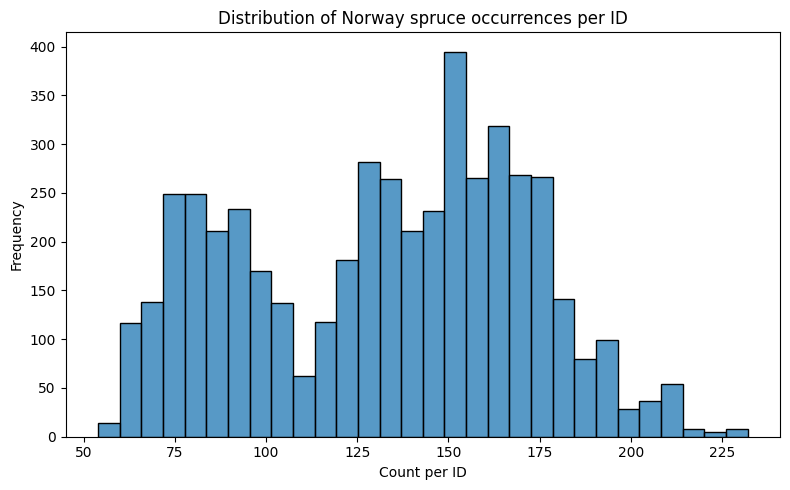

In [7]:
df_ns = df_trees[df_trees["species"] == "Norway_spruce"].groupby("id").count()
plt.figure(figsize=(8, 5))
sns.histplot(df_ns["species"], bins=30)
plt.title("Distribution of Norway spruce occurrences per ID")
plt.xlabel("Count per ID")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

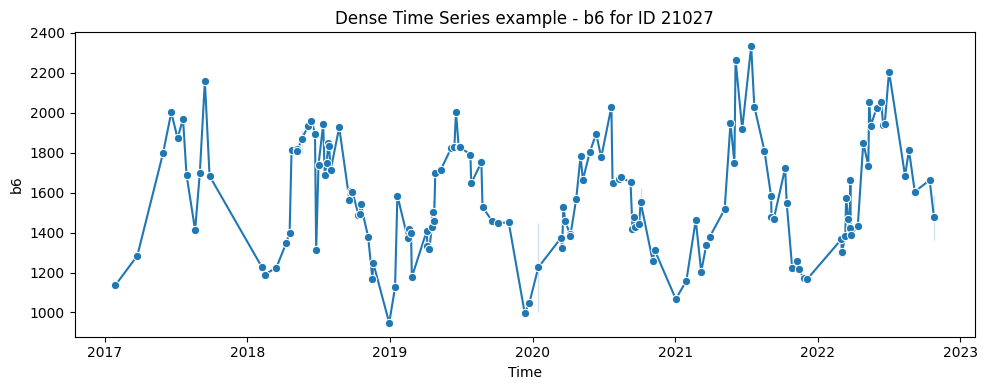

In [8]:
df_sub = df_trees[df_trees["id"] == 21027]

plt.figure(figsize=(10, 4))
sns.lineplot(data=df_sub, x="time", y="b6", marker="o")
plt.title("Dense Time Series example - b6 for ID 21027")
plt.xlabel("Time")
plt.ylabel("b6")
plt.tight_layout()
plt.show()

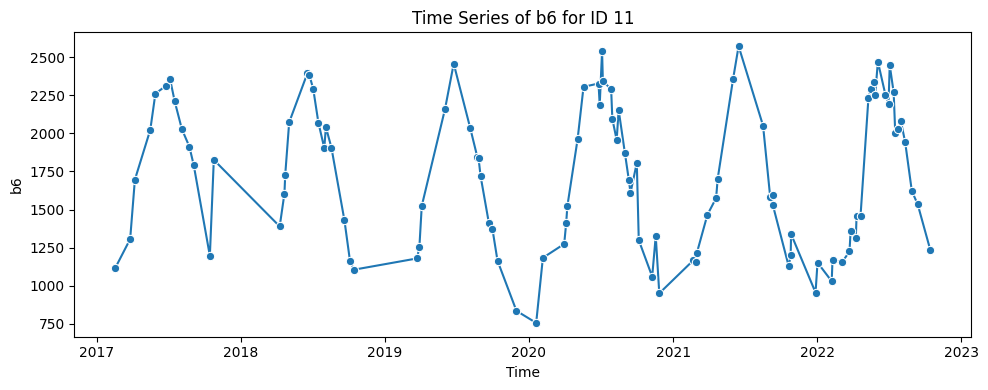

In [9]:
df_sub = df_trees[df_trees["id"] == 11]

plt.figure(figsize=(10, 4))
sns.lineplot(data=df_sub, x="time", y="b6", marker="o")
plt.title("Time Series of b6 for ID 11")
plt.xlabel("Time")
plt.ylabel("b6")
plt.tight_layout()
plt.show()

In [10]:
example_id = 8999

In [13]:
print(
    f"Old dataframe lenght for ID {example_id}: {len(df_trees[df_trees['id'] == example_id])}"
)
print(
    f"New dataframe lenght for ID {example_id}: {len(df_aug_all[df_aug_all['id'] == example_id])}"
)

Old dataframe lenght for ID 8999: 100
New dataframe lenght for ID 8999: 152


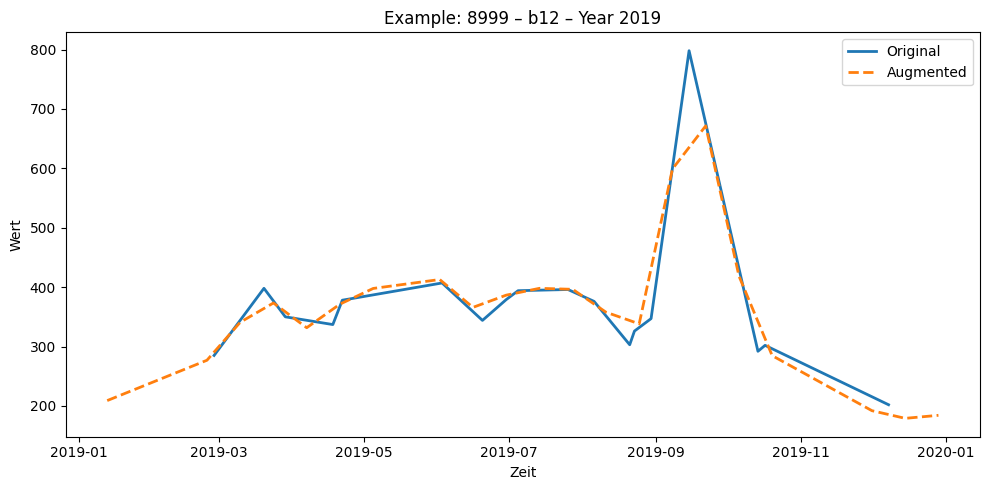

In [ ]:
df_trees["year"] = df_trees["time"].dt.year
df_aug_all["year"] = df_aug_all["time"].dt.year


def compare_species_year(year, id, band="b12"):
    df_orig = df_trees[(df_trees["year"] == year) & (df_trees["id"] == id)].sort_values(
        "time"
    )

    df_aug = df_aug_all[
        (df_aug_all["year"] == year) & (df_aug_all["id"] == id)
    ].sort_values("time")

    plt.figure(figsize=(10, 5))
    sns.lineplot(x="time", y=band, data=df_orig, label="Original", linewidth=2)
    sns.lineplot(
        x="time", y=band, data=df_aug, label="Augmented", linewidth=2, linestyle="--"
    )

    plt.title(f"Example: {id} – {band} – Year {year}")
    plt.xlabel("Zeit")
    plt.ylabel("Wert")
    plt.legend()
    plt.tight_layout()
    plt.show()


compare_species_year(2019, example_id, "b12")

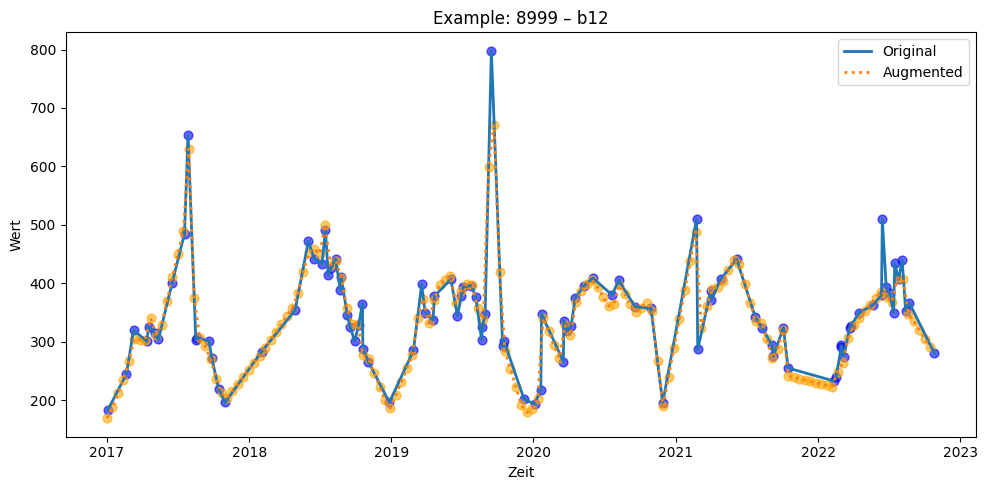

In [ ]:
def compare_species_year(id, band="b12"):
    df_orig = df_trees[df_trees["id"] == id].sort_values("time")
    df_aug = df_aug_all[df_aug_all["id"] == id].sort_values("time")

    plt.figure(figsize=(10, 5))
    sns.lineplot(x="time", y=band, data=df_orig, label="Original", linewidth=2)
    sns.lineplot(
        x="time", y=band, data=df_aug, label="Augmented", linewidth=2, linestyle=":"
    )
    plt.scatter(df_orig["time"], df_orig[band], color="blue", s=40, alpha=0.6)
    plt.scatter(df_aug["time"], df_aug[band], color="orange", s=40, alpha=0.6)

    plt.title(f"Example: {id} – {band}")
    plt.xlabel("Zeit")
    plt.ylabel("Wert")
    plt.legend()
    plt.tight_layout()
    plt.show()


compare_species_year(example_id, "b12")

<div class="alert-info">
The augmented data accurately capture the characteristics of the time series. While the peaks appear slightly smoothed, this is acceptable, as such variations may also result from noise.
</div>

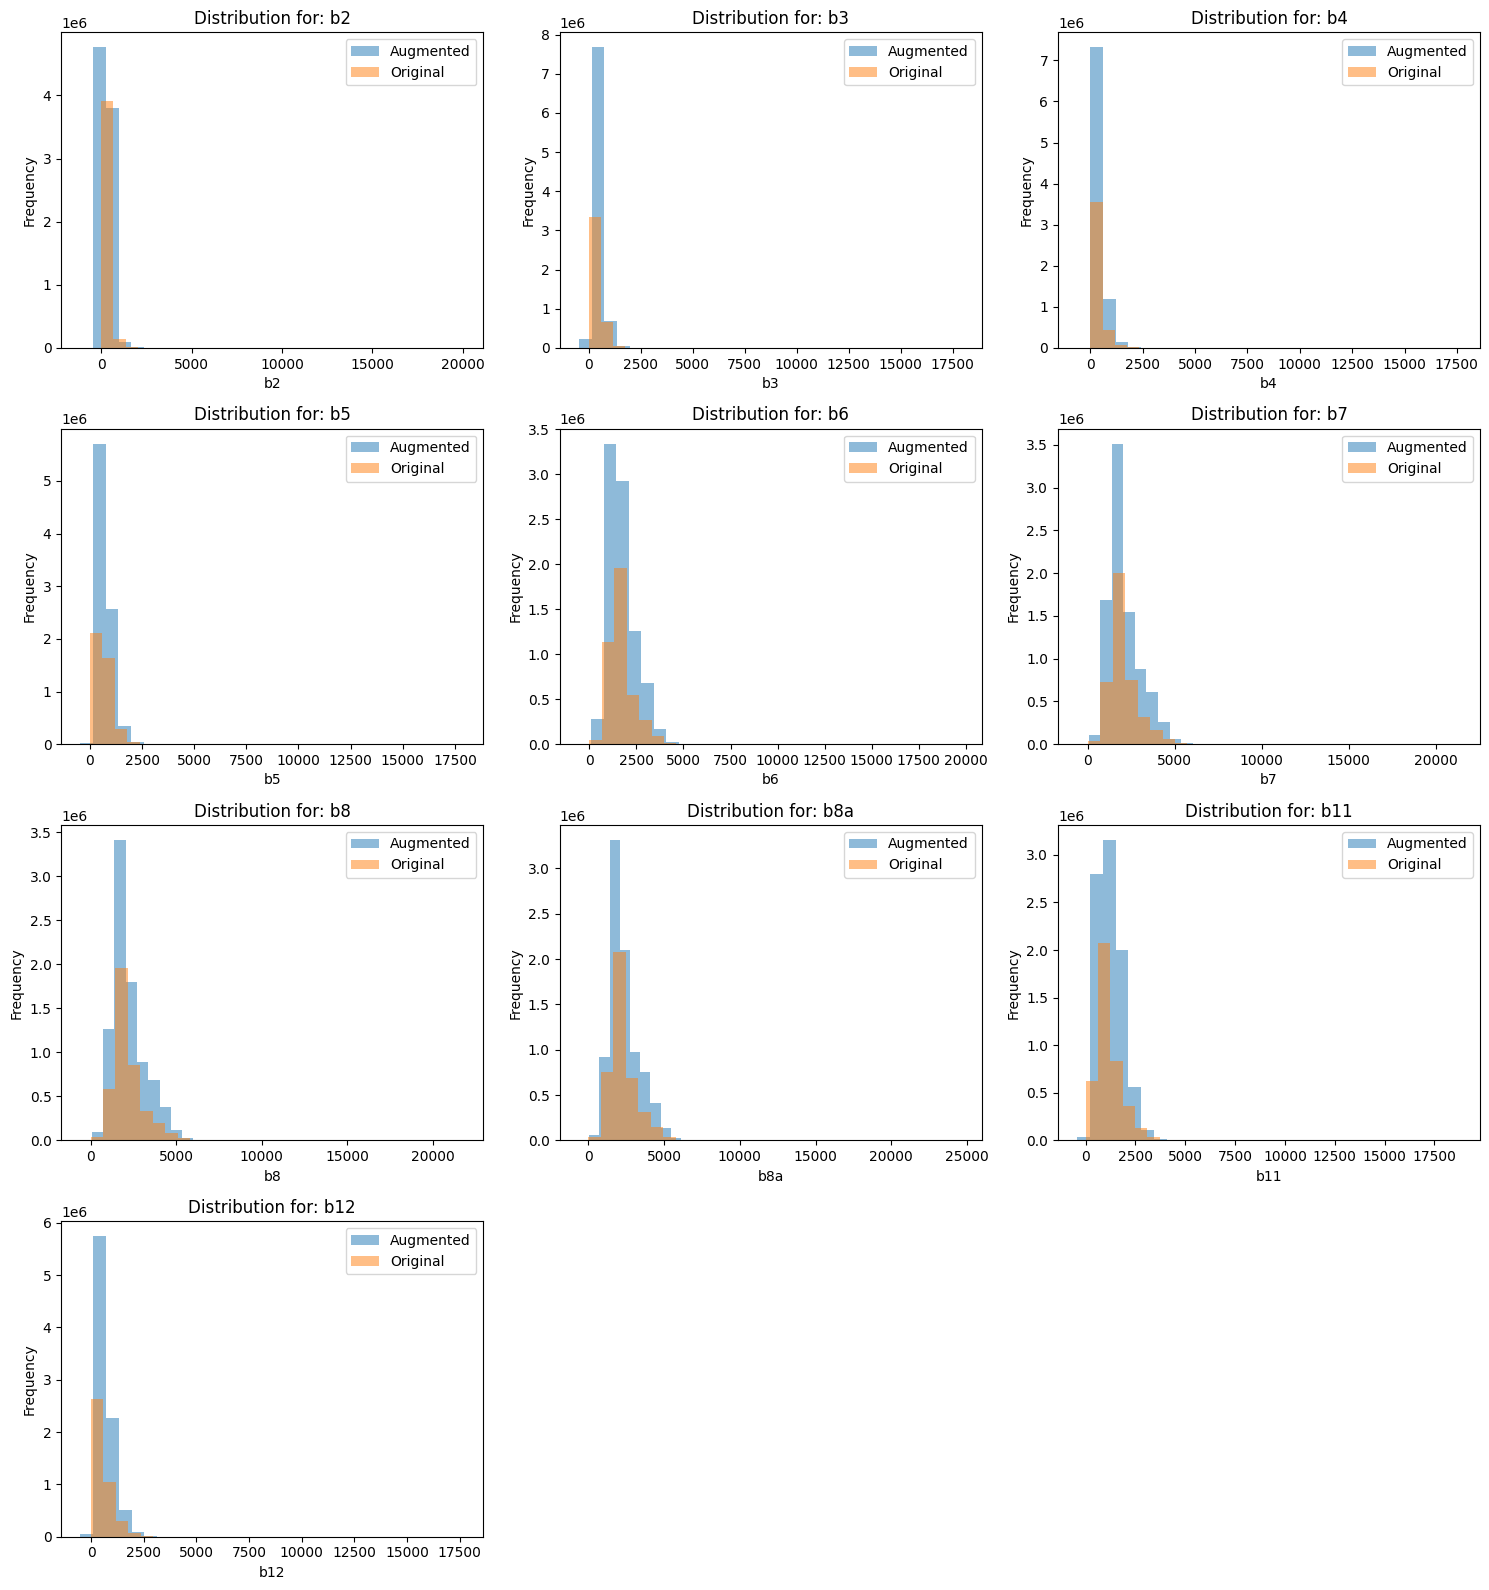

In [ ]:
n_cols = 3
n_rows = -(-len(spectral_bands) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(spectral_bands):
    ax = axes[i]
    ax.hist(df_aug_all[col].dropna(), bins=30, alpha=0.5, label="Augmented")
    ax.hist(df_trees[col].dropna(), bins=30, alpha=0.5, label="Original")
    ax.set_title(f"Distribution for: {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

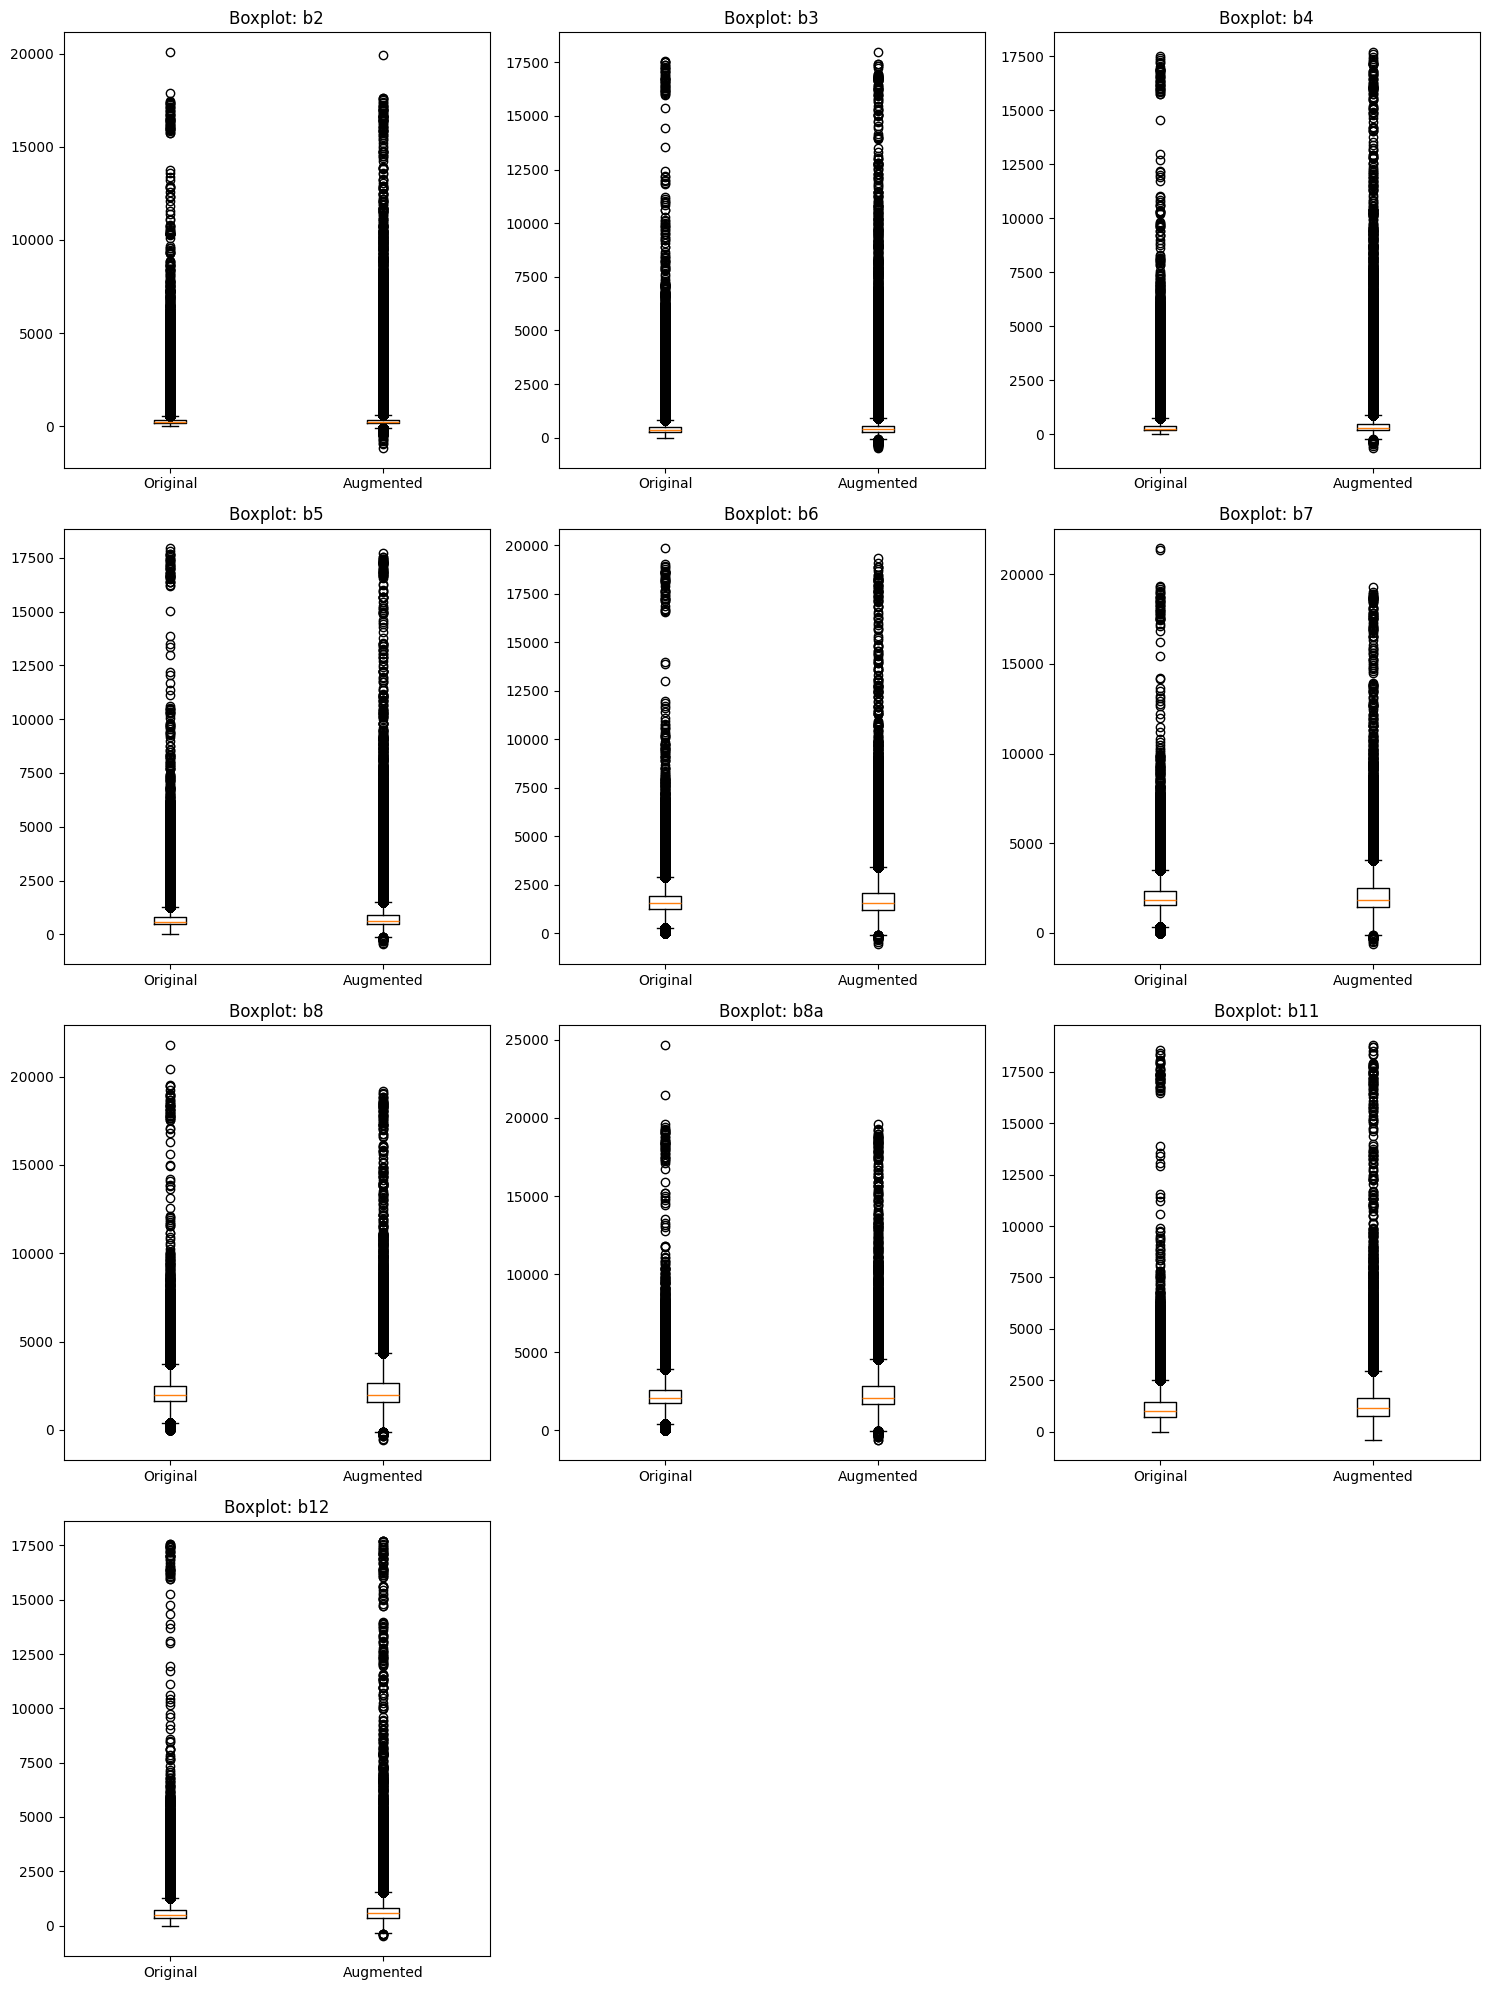

In [ ]:
n_cols = 3
n_rows = -(-len(spectral_bands) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(spectral_bands):
    ax = axes[i]
    ax.boxplot(
        [df_trees[col].dropna(), df_aug_all[col].dropna()],
        labels=["Original", "Augmented"],
    )
    ax.set_title(f"Boxplot: {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<div class="alert-info">
It can be seen that the distribution of the augmented data is almost identical to that of the original data. However, a more detailed analysis is difficult, as the outliers shown in the boxplot exhibit a very high variance.
</div>

### 2. All classes should be equaly distributed

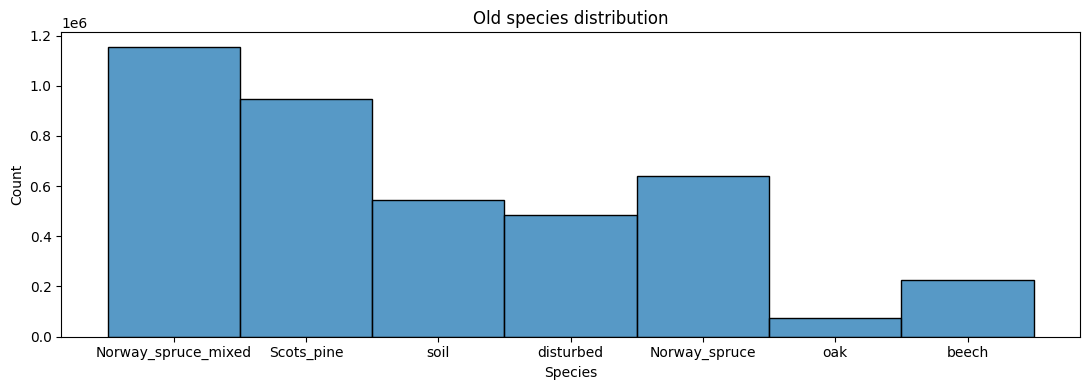

In [19]:
plt.figure(figsize=(11, 4))
sns.histplot(data=df_trees, x="species", discrete=True)
plt.title("Old species distribution")
plt.xlabel("Species")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

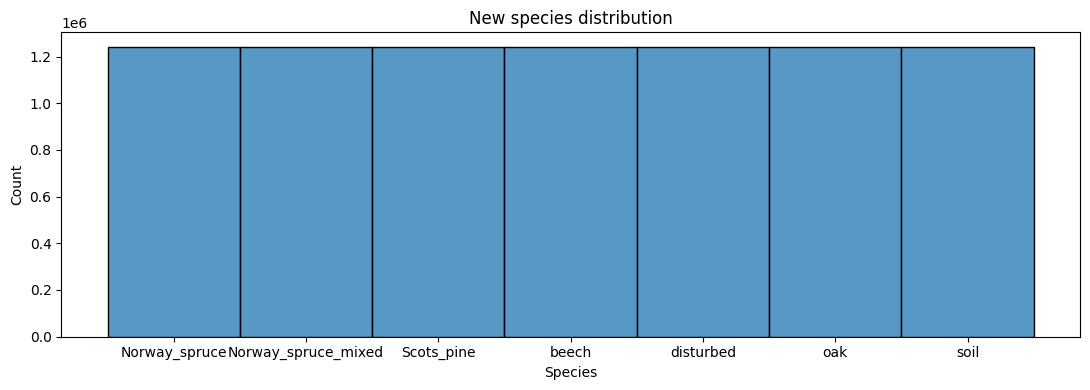

In [20]:
plt.figure(figsize=(11, 4))
sns.histplot(data=df_aug_all, x="species", discrete=True)
plt.title("New species distribution")
plt.xlabel("Species")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

<div class="alert-info">
It can be observed that the distribution of the individual classes becomes significantly more balanced after augmentation. However, there is now a risk that, due to the oversampling of smaller classes, some information may be lost. This needs to be validated within the models. Nevertheless, it can be shown that data augmentation can be effectively used to adjust class sizes.
</div>